
# COVID-Team-1
### Dr. Mohanty
### Christopher Brantley
### CSC 405 01
### Last Updated: 10/27/2020
### I, Christopher Brantley, have abided by the UNCG academic policy.

In [1]:
# Changing directory so we can import covid_data.
import os 
os.chdir("../")

## Imports.

In [2]:
import ipynb
from ipynb.fs.full import covid_data as cd
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

## Pandas Display Options.

In [3]:
# Telling pandas not convert to html tags.
pd.set_option('display.html.table_schema', True)
# Max columns and rows to display.
pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 8)

### Data Paths

In [4]:
# Relative to "../"
_state_daily_cases = "./chris/DATA/state_county_daily_cases.csv"
_state_daily_deaths = "./chris/DATA/state_county_daily_deaths.csv"

_state_weekly_casees = "./chris/DATA/state_county_weekly_cases.csv"
_state_weekly_deaths = "./chris/DATA/state_county_weekly_deaths.csv"

_state_county_weekly_stats_cases = "./chris/DATA/state_county_weekly_stats_cases.csv"
_state_county_weekly_stats_deaths = "./chris/DATA/state_county_weekly_stats_deaths.csv"

_demographic_housing_data = "./chris/DATA/HOUSING/housing.csv"

# Generate weekly statistics (mean, median, mode) for number of cases and deaths across a specific state.


### Generating daily new cases for State by county.

In [5]:
# Gets the daily new cases for any state and exports to csv.
def state_daily_cases_to_csv(_state):
    df_primary_data = cd.get_covid_primary_data()
    # Get all columns that have County or cases.
    df_state_cases = df_primary_data[df_primary_data.State == _state].filter(regex = "County|cases")
    # Setting index as county name.
    df_state_cases.set_index("County Name", inplace = True)
    # Creating new dataframe with county names as index.
    df_daily_cases = pd.DataFrame(index = [df_state_cases.index])
    # Getting number of days by getting number of columns that contain cases keyword.
    number_days = len(df_state_cases.filter(regex = "cases").columns)
    #  We iterate from the end so we will utilize negative values here.
    for day in range(-1, -number_days, -1):
        # Get the column name of day of cases.
        column_name = df_state_cases.columns[day]
        # Get the current case values and subtract the previous days.
        column_value = df_state_cases.iloc[:, day].sub(df_state_cases.iloc[:, day - 1]).values
        # Insert into dataframe the day of cases and the number of new cases.
        df_daily_cases.insert(0, column_name, column_value)
    # Because the first day has no preceding cases we will insert these as is.
    first_column_name = df_state_cases.columns[0]
    first_column_values = df_state_cases.iloc[:, 0:1].values
    df_daily_cases.insert(0, first_column_name, first_column_values)
    # We will export the data.
    df_daily_cases.to_csv(_state_daily_cases)

### Generating daily new deaths for State by county.

In [6]:
# Gets the daily new deaths and exports to csv.
def state_daily_deaths_to_csv(state):
    # First get our primary data.
    df_primary_data = cd.get_covid_primary_data()
    # Find any columns that are containing keywords county/deaths.
    df_state_deaths = df_primary_data[df_primary_data.State == state].filter(regex = "County|deaths")
    # Setting county name as the index.
    df_state_deaths.set_index("County Name", inplace = True)
    # Create new dataframe to hold daily new deaths, with index of counties.
    df_daily_deaths = pd.DataFrame(index = [df_state_deaths.index])
    # Get number of recorded days by the number of columns that exist.
    number_days = len(df_state_deaths.filter(regex = "deaths").columns)
    # We start at the end and move to the front of data so we utilize negative values.
    for day in range(-1, - number_days, -1):
        # Get the current column name for date value.
        column_name = df_state_deaths.columns[day]
        # Get the current daily death value and subtract the previous daily death value.
        # This yields daily new death value.
        column_values = df_state_deaths.iloc[:, day].sub(df_state_deaths.iloc[:, day - 1]).values
        # Insert the daily death column/value into the dataframe.
        df_daily_deaths.insert(0, column_name, column_values)
    # The first value does not have a preceding day so we will just copy these values as is.
    first_column_name = df_state_deaths.columns[0]
    first_column_values = df_state_deaths.iloc[:, 0:1].values
    df_daily_deaths.insert(0, first_column_name, first_column_values)
    # Export data to csv.
    df_daily_deaths.to_csv(_state_daily_deaths)

### Accessor methods for State Daily Cases and Deaths.

In [7]:
# Accessor method for state daily cases by county.
def get_state_daily_cases(_state):
    """Returns dataframe containing state daily cases by county."""
    state_daily_cases_to_csv(_state)
    return pd.read_csv(_state_daily_cases, index_col=[0])
    
# Accessor method for state daily deaths by county.
def get_state_daily_deaths(_state):
    """Returns dataframe containing state daily deaths by county."""
    state_daily_deaths_to_csv(_state)
    return pd.read_csv(_state_daily_deaths, index_col=[0])

### Accessor/Generator for Normalized Daily Cases

In [8]:
# Generates daily normalized cases.
def state_daily_cases_normalized(_state):
    # Get the covid primary data.
    df_primary_data = cd.get_covid_primary_data()
    # Get all columns that contain keywords County/cases.
    df_state_cases = df_primary_data[df_primary_data.State == _state].filter(regex = "County|cases")
    # Set the county name as index.
    df_state_cases.set_index("County Name", inplace = True)
    # Create daily cases dataframe with index of counties.
    df_daily_cases = pd.DataFrame(index = [df_state_cases.index])
    # Get the relevant state population data.
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    # Set the county name as index.
    df_state_pop.set_index("County Name", inplace = True)
    # Get the number of days as the number of columns that contain cases as keyword.
    number_days = len(df_state_cases.filter(regex = "cases").columns)
    # We will work in reverse, end to front of dataframe.
    for day in range(-1, -number_days, -1):
        # Get the column name for date value.
        column_name = df_state_cases.columns[day]
        # Get the current day subtracting the pror day.
        column_value = df_state_cases.iloc[:, day].sub(df_state_cases.iloc[:, day - 1]).values
        # Insert extracted date/value combo to df_daily_cases.
        df_daily_cases.insert(0, column_name, column_value)
    # We iterate over each county.
    for county in df_state_cases.index.values:
        # Get the population for current county.
        pop = df_state_pop.loc[county,"population"]
        # Swap the values out for the normalized value.
        df_daily_cases.loc[county, :] = \
        df_daily_cases.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values
    # We will not need to subtract the prior day from the first day so we just apply normalization.
    first_column_name = df_state_cases.columns[0]
    first_column_values = df_state_cases.iloc[:, 0:1].apply(lambda x: round(((x / pop) * 100000), 0)).values
    df_daily_cases.insert(0, first_column_name, first_column_values)
    # We store the countyFIPS to aid in merging.
    df_daily_cases.insert(0, "countyFIPS", df_primary_data.countyFIPS[df_primary_data.State == _state].values)
    
    return df_daily_cases

In [9]:
# Generates log10 daily cases.
def state_daily_cases_log10(_state):
    # We get the primary covid data.
    df_primary_data = cd.get_covid_primary_data()
    # Get specific state and all columns that contain keywords.
    df_state_cases = df_primary_data[df_primary_data.State == _state].filter(regex = "County|cases")
    # Set index as county names.
    df_state_cases.set_index("County Name", inplace = True)
    # Crate new dataframe to hold daily cases, index is counties.
    df_daily_cases = pd.DataFrame(index = [df_state_cases.index])
    # Get the relevant county populations.
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    # Set county name as index.
    df_state_pop.set_index("County Name", inplace = True)
    # Get number days as number of columns that contain keyword.
    number_days = len(df_state_cases.filter(regex = "cases").columns)
    # Start at the end and work towards the front of dataframe.
    for day in range(-1, -number_days, -1):
        # Get the current column name for date info.
        column_name = df_state_cases.columns[day]
        # Get the current daily value subtracting the prior daily value.
        column_value = df_state_cases.iloc[:, day].sub(df_state_cases.iloc[:, day - 1]).values
        # Insert the extracted info into our daily dataframe.
        df_daily_cases.insert(0, column_name, column_value)
    # For each county we...
    for county in df_state_cases.index.values:
        # Get the county population.
        pop = df_state_pop.loc[county,"population"]
        # We normalize and then take get log10 value.
        df_daily_cases.loc[county, :] = \
        np.log10(df_daily_cases.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values)
    # No prior day exists for the first date so we just normalize and calculate log10 value.
    first_column_name = df_state_cases.columns[0]
    first_column_values = np.log10(df_state_cases.iloc[:, 0:1]\
                                   .apply(lambda x: round(((x / pop) * 100000), 0)).values)
    df_daily_cases.insert(0, first_column_name, first_column_values)
    
    return df_daily_cases

### Accessor/Generator for Normalized Daily Deaths

In [10]:
# Generates normalized daily deaths.
def state_daily_deaths_normalized(_state):
    # Get covid primary data.
    df_primary_data = cd.get_covid_primary_data()
    # Get columns that match keywords County/deaths.
    df_state_deaths = df_primary_data[df_primary_data.State == _state].filter(regex = "County|deaths")
    # Set index as county names.
    df_state_deaths.set_index("County Name", inplace = True)
    # Create new dataframe with index as county names.
    df_daily_deaths = pd.DataFrame(index = [df_state_deaths.index])
    # Get state specific population information.
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    # Set state pop index as county name.
    df_state_pop.set_index("County Name", inplace = True)
    # Calculate number days as number of columns that contain death keyword.
    number_days = len(df_state_deaths.filter(regex = "deaths").columns)
    # Work from the back of dataframe towards the front.
    for day in range(-1, - number_days, -1):
        # Extract the current date value.
        column_name = df_state_deaths.columns[day]
        # Get the current value and subtract the prior daily value.
        column_values = df_state_deaths.iloc[:, day].sub(df_state_deaths.iloc[:, day - 1]).values
        # Insert information into the daily dataframe.
        df_daily_deaths.insert(0, column_name, column_values)
    # For each county.
    for county in df_daily_deaths.index.values:
        # Get the county's population.
        pop = df_state_pop.loc[county,"population"]
        # Apply normalization to each county by respective population.
        df_daily_deaths.loc[county, :] = \
        df_daily_deaths.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values
    # Normalize and insert first row of data, no prior date exists to calculate daily value.
    first_column_name = df_state_deaths.columns[0]
    first_column_values = df_state_deaths.iloc[:, 0:1].apply(lambda x:(x / pop) * 100000).values
    df_daily_deaths.insert(0, first_column_name, first_column_values)
    return df_daily_deaths

In [11]:
# Gnerates log10 daily deaths.
def state_daily_deaths_log10(_state):
    # Get primary data.
    df_primary_data = cd.get_covid_primary_data()
    # Retrieve all columns containing keywords.
    df_state_deaths = df_primary_data[df_primary_data.State == _state].filter(regex = "County|deaths")
    # Set index as county names.
    df_state_deaths.set_index("County Name", inplace = True)
    # Create new dataframe to hold daily deaths with county names as index.
    df_daily_deaths = pd.DataFrame(index = [df_state_deaths.index])
    # Get the state specific population information.
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    # Set index as county name.
    df_state_pop.set_index("County Name", inplace = True)
    # Let number days equal the length of the columns that contain deaths as keyword.
    number_days = len(df_state_deaths.filter(regex = "deaths").columns)
    # Work from back to front of database.
    for day in range(-1, - number_days, -1):
        # Get the current date value.
        column_name = df_state_deaths.columns[day]
        # Get the daily deaths, current day - prior day.
        column_values = df_state_deaths.iloc[:, day].sub(df_state_deaths.iloc[:, day - 1]).values
        # Insert extracted information as daily deaths.
        df_daily_deaths.insert(0, column_name, column_values)
    # For each county in df_daily_deaths.
    for county in df_daily_deaths.index.values:
        # Get county population.
        pop = df_state_pop.loc[county,"population"]
        # Apply population normalization and apply log10.
        df_daily_deaths.loc[county, :] = \
        np.log10(df_daily_deaths.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values)
    # Apply normalization and log10 to first date value.
    first_column_name = df_state_deaths.columns[0]
    first_column_values = np.log10(df_state_deaths.iloc[:, 0:1].apply(lambda x:(x / pop) * 100000).values)
    df_daily_deaths.insert(0, first_column_name, first_column_values)
    return df_daily_deaths

### Generating Weekly Cases for State by County.

In [12]:
# Generates weekly new cases.
def state_weekly_cases_to_csv(state):
    # Get daily cases.
    df_county_cases = get_state_daily_cases(state)
    # Get shape of dataframe where all columns contain cases as keyword as number days.
    number_days = df_county_cases.filter(regex = "cases").shape[1]
    # We will get the number of days needed to make number_days divisible by 7 to calculate number of weeks.
    number_weeks = int(((7 - number_days % 7) + number_days) / 7)

    index_county = []
    index_weeks = []
    # Create each week for each county for multi index purposes.
    for county in df_county_cases.index.values:
        for week in range(0, number_weeks, 1):
            index_county.append(county)
            index_weeks.append("week " + str(week + 1))
    # Create new dataframe with multi index and columns as cases.
    df_county_weekly = pd.DataFrame(index = [index_county, index_weeks],\
                                   columns = ["cases"])
    # For each county.
    for county in df_county_cases.index.values:
        # For each increment of seven columns.
        for column in range(0, df_county_cases.shape[1], 7):
            # Find the weekly sum and assign it to proper index.
            df_county_weekly.loc[(county, "week " + str((column // 7) + 1))] = \
                df_county_cases.loc[county].iloc[column:column + 7].sum()
    df_county_weekly.to_csv(_state_weekly_casees)

### Generating Weekly Deaths for State by County.

In [13]:
# Generates weekly new deaths.
def state_weekly_deaths_to_csv(state):
    # Get state daily deaths.
    df_county_deaths = get_state_daily_deaths(state)
    # Get number of columns that contain keyword deaths.
    number_days = df_county_deaths.filter(regex = "deaths").shape[1]
    # Make number_days divisible by seven and calculate number of weeks.
    number_weeks = int(((7 - number_days % 7) + number_days) / 7)
    
    index_county = []
    index_weeks = []
    # Create multi index of each week for each county.
    for county in df_county_deaths.index.values:
        for week in range(0, number_weeks, 1):
            index_county.append(county)
            index_weeks.append("week " + str(week + 1))
    # Create dataframe with multi index and columns as deaths.
    df_county_weekly = pd.DataFrame(index = [index_county, index_weeks],
                                    columns = ["deaths"])
    # For each county.
    for county in df_county_deaths.index.values:
        # For each seven daily deaths.
        for column in range(0, df_county_deaths.shape[1], 7):
            # Calculate the sum and store it in proper index of weekly deaths.
            df_county_weekly.loc[(county, "week " + str((column // 7) + 1))] = \
                df_county_deaths.loc[county].iloc[column:column + 7].sum()
    df_county_weekly.to_csv(_state_weekly_deaths)

### Accessor Methods for State Weekly Cases and Deaths

In [14]:
# Accessor method for state weekly cases by county.
def get_state_weekly_cases(_state):
    state_weekly_cases_to_csv(_state)
    # index_col is necessary to show that 0, 1 make up a multiindex.
    return pd.read_csv(_state_weekly_casees, index_col=[0, 1])
    
# Accessor method for state weekly deaths by county.
def get_state_weekly_deaths(_state):
    state_weekly_deaths_to_csv(_state)
    # index_col is necessary to show that 0, 1 make up a multiindex.
    return pd.read_csv(_state_weekly_deaths, index_col=[0, 1])

### Generating Weekly Case Stats for State by county.

In [15]:
# Generates weekly stats for state cases.
def state_weekly_cases_stats_to_csv(_state,):
    # Get primary data.
    df_primary_data = cd.get_covid_primary_data()
    # Get columns that contain county/population for specific state.
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    # Set county name as index.
    df_state_pop.set_index("County Name", inplace = True)
    # Get weekly case values.
    df_weekly_normalized = get_state_weekly_cases(_state)

    # Normalizing weekly cases to 100,000.
    # For each county.
    for county in df_weekly_normalized.index.get_level_values(0).unique():
        # Get the county's population.
        pop = df_state_pop.loc[county, "population"]
        # Normalize and round so that mode can be calculated.
        df_weekly_normalized.loc[county, :] = \
        df_weekly_normalized.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values
    # Create new dataframe with county names as index, columns as statistical measurements.
    df_county_normalized = pd.DataFrame(index = [df_weekly_normalized.index.get_level_values(0).unique()],\
                                   columns = ["mean", "median", "mode"])
    # For each county.
    for county in df_weekly_normalized.index.get_level_values(0).unique():
        # Calculate statistical measurements.
        df_county_normalized.loc[county, "mean"] = df_weekly_normalized.loc[county].mean()[0]
        df_county_normalized.loc[county, "median"] = df_weekly_normalized.loc[county].median()[0]
        df_county_normalized.loc[county, "mode"] = df_weekly_normalized.loc[county].mode().values[0,0]
    df_county_normalized.to_csv(_state_county_weekly_stats_cases)

### Generating Weekly Deaths Stats for State by county.

In [16]:
# Generates weekly stats for state deaths.
def state_weekly_deaths_stats_to_csv(_state,):
    # Get covid primary data.
    df_primary_data = cd.get_covid_primary_data()
    # Get state specific data where columns match County and population keywords.
    df_state_pop = df_primary_data[df_primary_data.State == _state].filter(regex = "County|population")
    # Set index as county names.
    df_state_pop.set_index("County Name", inplace = True)
    # Get weekly deaths.
    df_weekly_normalized = get_state_weekly_deaths(_state)

    # Normalizing deaths to 100,000.
    # For each county.
    for county in df_weekly_normalized.index.get_level_values(0).unique():
        # Get county's population.
        pop = df_state_pop.loc[county, "population"]
        # Normalize weekly data.
        df_weekly_normalized.loc[county, :] = \
        df_weekly_normalized.loc[county, :].apply(lambda x: round(((x / pop) * 100000), 0)).values
    # Create new dataframe with county names as index, columns as statistical measurements.
    df_county_normalized = pd.DataFrame(index = [df_weekly_normalized.index.get_level_values(0).unique()],\
                                   columns = ["mean", "median", "mode"])
    # For each county.
    for county in df_weekly_normalized.index.get_level_values(0).unique():
        # Calculate statistical measurements.
        df_county_normalized.loc[county, "mean"] = round(df_weekly_normalized.loc[county].mean()[0], 0)
        df_county_normalized.loc[county, "median"] = round(df_weekly_normalized.loc[county].median()[0])
        df_county_normalized.loc[county, "mode"] = round(df_weekly_normalized.loc[county].mode().values[0,0], 0)
    df_county_normalized.to_csv(_state_county_weekly_stats_deaths)

### Accessor Methods for State Weekly Cases and Deaths

In [17]:
# Accessor method for state weekly cases by county.
def get_county_weekly_cases_stats(_state):
    state_weekly_cases_stats_to_csv(_state)
    return pd.read_csv(_state_county_weekly_stats_cases, index_col=[0])
    
# Accessor method for state weekly deaths by county.
def get_county_weekly_deaths_stats(_state):
    state_weekly_deaths_stats_to_csv(_state)
    return pd.read_csv(_state_county_weekly_stats_deaths, index_col=[0])

### Generator and Accessor for  Weekly Cases Stats for State.

In [18]:
# Generates county overall statistical measurements for both cases/deaths.
def county_weekly_stats_overall(_state):
    # Create dataframe to hold states weekly cases/deaths as index, statistical measurements as columns.
    df_overall_weekly_county = pd.DataFrame(index = [_state + " weekly cases",
                                 _state + " weekly deaths"],
                 columns = ["mean", "median", "mode"])
    # For each case/death, weekly case stats, weekly death stats get overall statistical measurement.
    for data_type, dataset in zip(tuple(df_overall_weekly_county.index.values),\
                                  (get_county_weekly_cases_stats(_state),\
                                   get_county_weekly_deaths_stats(_state))):
        # Calculating overall statistical measurements.
        df_overall_weekly_county.loc[data_type, "mean"] = dataset["mean"].mean()
        df_overall_weekly_county.loc[data_type, "median"] = dataset["median"].median()
        df_overall_weekly_county.loc[data_type, "mode"] = dataset["mode"].mode()[0]

    return df_overall_weekly_county

# Fit a distribution to the number of COVID-19 cases of a state. 

### Graphically plot the distribution and describe the distribution statistics.

In [19]:
df_daily_county = get_state_daily_cases("FL")
# Calculate daily values for all counties.
df_daily_state = df_daily_county.sum()

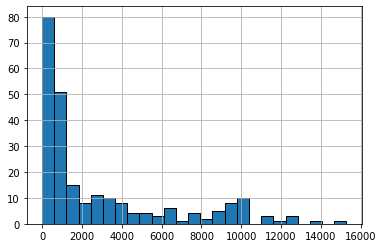

In [20]:
# Plot cases value and number of occurences of that value.
graph = df_daily_state.hist(bins = 25, ec = "black")

In [21]:
df_daily_state.skew()

1.4194890970262892

#### The calculated skew is positive which implies a right skewed graph.

In [22]:
df_daily_state.mean()

2801.8200836820083

#### We see that our mean is pulled to the right, but not by much.

In [23]:
df_daily_state.kurtosis()

0.9205771282583206

#### Kurtosis greater than 0 implies heavily skewed data.

### Describe why the distribution was chosen and its statistics in the report and the notebook. 

#### We are going to chose geometric distribution to model the data. This is because geometric distribution is used for discrete data, it can be used to measure success/failure, where success can be described as not having any case.

# Model a poission distribution of COVID-19 cases and deaths of a state and compare to other 5 states. For example, Number of new cases and deaths per 100,000 populations. (normalize by population, you can choose a different normalization factor that 100,000)

In [24]:
# Generating random states.
random_states = [x for x in np.random.choice(cd.get_covid_primary_data().State.unique(), 6)]
# Hard coding random states for consistency.
random_states = ['OH', 'KS', 'NE', 'AR', 'ID', 'ND']

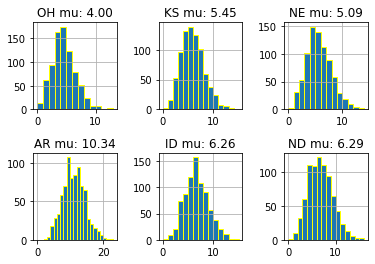

In [25]:
# Creating sub plot.
fig, axis = plt.subplots(2,3, gridspec_kw={'hspace': .5, 'wspace': .5})
# For loop for two rows and two three state pairs.
for x, states in zip((0,1), (random_states[0:3], random_states[3:])):
    # For loop for three columns, three state pairs.
    for y, state in zip((0,1,2), states):
        # Calculate the mean of cases.
        mu_cases = state_daily_cases_normalized(state).filter(regex = "cases").mean().mean()
        # Generate 800 data fit to mu_cases.
        d_poisson = stats.poisson.rvs(mu = mu_cases, size = 800)
        # Generate histogram.
        figure = pd.DataFrame(d_poisson).hist(range=(0,max(d_poisson) + 1)
                                    , bins=max(d_poisson)+1, ax = axis[x,y] , ec='yellow')
        # Set title.
        axis[x,y].title.set_text(state +" mu: {:.2f}".format(mu_cases))

#### Poisson shows number of successes during period of time. Y-axis represents the likelihood of occurences, the X-axis represents the number of occurences. For most graphs we can see that the average has a high likelihood but that the smaller the mean the higher the likelihood of mean due to decrease of bin size.

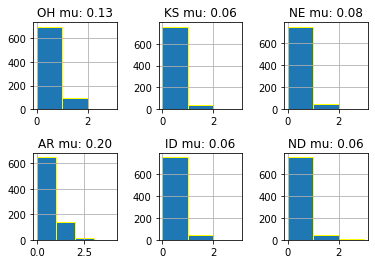

In [43]:
# Hard code random_states for consistency.
random_states = ['OH', 'KS', 'NE', 'AR', 'ID', 'ND']
# Create subplot.
fig, axis = plt.subplots(2,3, gridspec_kw={'hspace': .5, 'wspace': .5})
# For loop for two rows and two three state pairs.
for x, states in zip((0,1), (random_states[0:3], random_states[3:])):
    # For loop for three columns, three state pairs.
    for y, state in zip((0,1,2), states):
        # Calculate the mean of deaths.
        mu_cases = state_daily_deaths_normalized(state).filter(regex = "deaths").mean().mean()
        # Generate 800 data fit to mu_cases.
        d_poisson = stats.poisson.rvs(mu = mu_cases, size = 800)
        # Generate histogram.
        figure = pd.DataFrame(d_poisson).hist(range=(0,max(d_poisson) + 1)
                                    , bins=max(d_poisson)+1, ax = axis[x,y] , ec='yellow')
        # Set title.
        axis[x,y].title.set_text(state +" mu: {:.2f}".format(mu_cases))

#### The poisson distribution for daily deaths shows that the likelihood of having no deaths is very high. Almost all graphs are identical and we see that as the mu increases the bin increases.

# Model poission distributions for North Carolina counties COVID-19 in cases and deaths. For example, Number of new cases and deaths per 100,000 populations. 

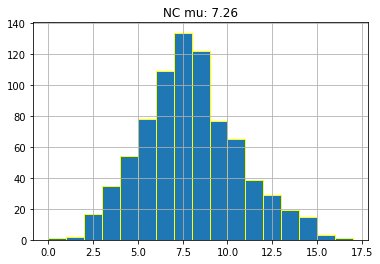

In [46]:
# Create subplot.
fig, axis = plt.subplots(1,1, gridspec_kw={'hspace': .5, 'wspace': .5})
# Calculate mean.
mu_cases = state_daily_cases_normalized("NC").filter(regex = "cases").mean().mean()
# Generate 800 data fit to mean.
d_poisson = stats.poisson.rvs(mu = mu_cases, size = 800)
# Create histogram.
figure = pd.DataFrame(d_poisson).hist(range=(0,max(d_poisson) + 1)
                            , bins=max(d_poisson)+1, ax = axis , ec='yellow')
# Set title.
axis.title.set_text("NC" +" mu: {:.2f}".format(mu_cases))

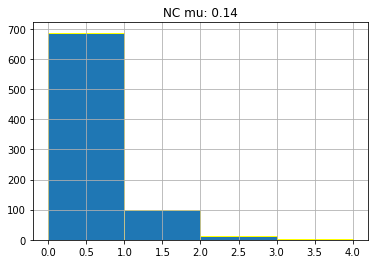

In [47]:
# Create subplot.
fig, axis = plt.subplots(1,1, gridspec_kw={'hspace': .5, 'wspace': .5})
# Calculate mean.
mu_cases = state_daily_deaths_normalized("NC").filter(regex = "deaths").mean().mean()
# Generate 800 data fit to mu cases.
d_poisson = stats.poisson.rvs(mu = mu_cases, size = 800)
# Create histogram.
figure = pd.DataFrame(d_poisson).hist(range=(0,max(d_poisson) + 1)
                            , bins=max(d_poisson)+1, ax = axis , ec='yellow')
# Set state and mean as title.
axis.title.set_text("NC" +" mu: {:.2f}".format(mu_cases))

# Perform corelation between Enrichment data variables and COVID-19 cases to observe any patterns.

#### We will check Florida counties for correlations between enrichment data and cases.

In [29]:
# Reading in housing data.
df_housing = pd.read_csv(_demographic_housing_data, index_col = 0)
# Reading in covid primary data.
df_florida = state_daily_cases_normalized("FL")

In [30]:
# Setting county names as index.
df_florida.insert(0, "county_name", [str(x[0]) for x in df_florida.index.values])
# Moving countyFIPS to index so that we may join the dataframes.
df_florida.set_index("countyFIPS", inplace = True)
display(df_florida)

,county_name,cases - 1/22/20,cases - 1/23/20,cases - 1/24/20,cases - 1/25/20,cases - 1/26/20,cases - 1/27/20,...,cases - 9/10/20,cases - 9/11/20,cases - 9/12/20,cases - 9/13/20,cases - 9/14/20,cases - 9/15/20,cases - 9/16/20
countyFIPS,,,,,,,,,,,,,,,
12001,Alachua County,0.0,0.0,0.0,0.0,0.0,0.0,...,32.0,49.0,79.0,59.0,57.0,38.0,58.0
12003,Baker County,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,51.0,21.0,41.0,38.0,38.0,41.0
12005,Bay County,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,22.0,21.0,13.0,6.0,15.0,7.0
12007,Bradford County,0.0,0.0,0.0,0.0,0.0,0.0,...,35.0,78.0,28.0,64.0,28.0,28.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12127,Volusia County,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,17.0,14.0,10.0,7.0,12.0,8.0
12129,Wakulla County,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,50.0,21.0,9.0,56.0,41.0,24.0
12131,Walton County,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,22.0,18.0,12.0,24.0,14.0,18.0
12133,Washington County,0.0,0.0,0.0,0.0,0.0,0.0,...,31.0,8.0,24.0,0.0,0.0,4.0,12.0


In [31]:
display(df_housing)

,population_male,population_female,sex_ratio,under_18,over_18,over_or_62,median_age,total_housing
countyFIPS,,,,,,,,
1103,59216,59873,98.9,27098,91991,25752,40.7,52284
6031,83591,67775,123.3,40773,110593,19049,32.0,46649
6053,221011,214583,103.0,114103,321491,74816,34.7,142414
6057,48808,50888,95.9,17079,82617,33053,50.5,54264
...,...,...,...,...,...,...,...,...
72021,80211,90269,88.9,29655,140825,43714,43.5,82901
72113,63943,69248,92.3,25672,107519,35167,42.5,65299
72135,34421,36673,93.9,14081,57013,12265,40.1,26421
72137,34856,39767,87.7,14009,60614,17405,42.0,34796


#### We see that some rows are missing, data is absent from the particular file I chose.

In [32]:
# Merging dataframes.
df_merged_data = pd.merge(df_florida, df_housing, on = "countyFIPS", how = "inner")
display(df_merged_data)

,county_name,cases - 1/22/20,cases - 1/23/20,cases - 1/24/20,cases - 1/25/20,cases - 1/26/20,cases - 1/27/20,...,population_female,sex_ratio,under_18,over_18,over_or_62,median_age,total_housing
countyFIPS,,,,,,,,,,,,,,,
12001,Alachua County,0.0,0.0,0.0,0.0,0.0,0.0,...,138527,94.9,48712,221244,46052,31.7,118966
12005,Bay County,0.0,0.0,0.0,0.0,0.0,0.0,...,93435,98.3,39688,145599,38857,39.6,104325
12009,Brevard County,0.0,0.0,0.0,0.0,0.0,0.0,...,307238,94.3,109627,487222,169932,47.2,280390
12011,Broward County,0.0,0.0,0.0,0.0,0.0,0.0,...,1000406,95.0,412226,1539034,395180,40.4,826949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12117,Seminole County,0.0,0.0,0.0,0.0,0.0,0.0,...,241877,93.4,98391,369441,88933,39.2,192255
12119,Sumter County,0.0,0.0,0.0,0.0,0.0,0.0,...,64634,99.2,9257,119497,81284,67.5,72372
12127,Volusia County,0.0,0.0,0.0,0.0,0.0,0.0,...,280284,95.4,96391,451147,157034,46.6,262107
12131,Walton County,0.0,0.0,0.0,0.0,0.0,0.0,...,36741,94.3,14377,56998,17904,44.4,53376


#### 

# Gender Correlation

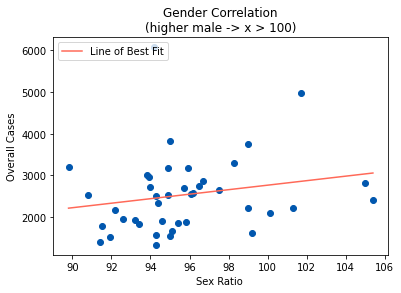

In [33]:
# Sorting by sex_ratio, in ascending order.
df_sex_ratio = df_merged_data.sort_values("sex_ratio", ascending = True)
sex_ratio = []
overall_cases = []
# Iterating over the tuples in the dataframe.
for county in df_sex_ratio.index.values:
    # Appending to sex_ratio sex_ratio for each county.
    sex_ratio.append(df_sex_ratio.loc[county, "sex_ratio"])
    # Appending to overall_cases each county total cases.
    overall_cases.append(df_sex_ratio.loc[county].filter(regex = "cases").sum())

# Creating plot.
fig, axis = plt.subplots(1,1)
# Creating scatter plot of sex_ratio and county cases.
axis.scatter(sex_ratio, overall_cases, color = "#0157AE")
axis.title.set_text("Gender Correlation\n(higher male -> x > 100)")
axis.set_ylabel("Overall Cases")
axis.set_xlabel("Sex Ratio ")
# Creating line of best fit.
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
m,b = np.polyfit(sex_ratio, overall_cases, 1)
# Plotting line of best fit.
t = axis.plot(sex_ratio, m * np.array(sex_ratio) + b, color = "#FF6958", label = "Line of Best Fit")
t = axis.legend(loc = "upper left")

#### The gender ratio is known to be dominant female when less than 100 and dominant male when greater than 100. Therefore, for gender we see a slight increase in cases as the male population increases, however this is not a strong trend. We would need to see more data to strongly suggest that higher male populations have higher covid cases. 

# Median Age Correlation

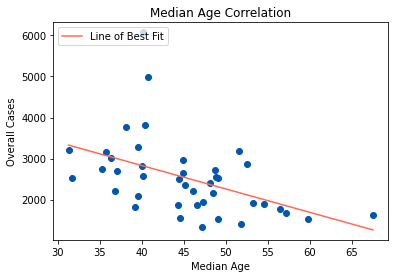

In [34]:
# Sorting by median_age, by ascending values.
df_median_age = df_merged_data.sort_values("median_age", ascending = True)
median_age = []
overall_cases = []
# Iterating over each row in dataframe.
for county in df_median_age.index.values:
    # Getting the median age value.
    median_age.append(df_median_age.loc[county, "median_age"])
    # Getting the overall cases.
    overall_cases.append(df_median_age.loc[county].filter(regex = "cases").sum())

# Creating plot.
fig, axis = plt.subplots(1,1)
# Creating scatter plot of median_age and overall_cases.
axis.scatter(median_age, overall_cases, color = "#0157AE")
axis.title.set_text("Median Age Correlation")
axis.set_ylabel("Overall Cases")
axis.set_xlabel("Median Age")
# Creating line of best fit.
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
m,b = np.polyfit(median_age, overall_cases, 1)
# Plotting line of best fit.
t = axis.plot(median_age, m * np.array(median_age) + b, color = "#FF6958", label = "Line of Best Fit")
t = axis.legend(loc = "upper left")

#### We can see from median age that the numer of overall cases decreases as the median age of population decreases.

# Under 18 Population Percentage

In [35]:
# Getting dataframe.
df_under_18 = df_merged_data
under_18_percentage = []
# Iterating over counties.
for county in df_under_18.index.values:
    # Dividing the under 18 population by the total population.
    under_18_percentage.append(df_under_18.loc[county].under_18\
    / (df_under_18.loc[county].over_18\
    + df_under_18.loc[county].under_18))
# Populating dataframe with the under 18 percent data.
df_under_18["under_18_percent"] = under_18_percentage

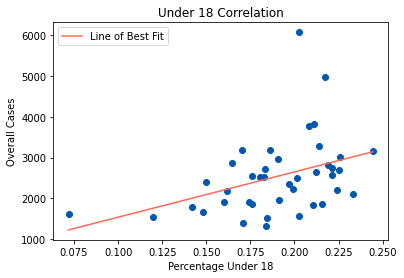

In [36]:
# Sorting by under_18_percent, by ascending values.
df_under_18 = df_merged_data.sort_values("under_18_percent", ascending = True)
under_18 = []
overall_cases = []
# Iterating over each row in dataframe.
for county in df_under_18.index.values:
    # Getting the under_18 age value.
    under_18.append(df_under_18.loc[county, "under_18_percent"])
    # Getting the overall cases.
    overall_cases.append(df_under_18.loc[county].filter(regex = "cases").sum())

# Creating plot.
fig, axis = plt.subplots(1,1)
# Creating scatter plot of under_18 and overall_cases.
axis.scatter(under_18, overall_cases, color = "#0157AE")
axis.title.set_text("Under 18 Correlation")
axis.set_ylabel("Overall Cases")
axis.set_xlabel("Percentage Under 18")
# Creating line of best fit.
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
m,b = np.polyfit(under_18, overall_cases, 1)
# Plotting line of best fit.
t = axis.plot(under_18, m * np.array(under_18) + b, color = "#FF6958", label = "Line of Best Fit")
t = axis.legend(loc = "upper left")

#### We can see that as the under 18 population percentage increases that the overall cases increase.

# Over 18 and Under 62 Percentage

In [37]:
# Getting dataframe.
df_middle = df_merged_data
middle_percentage = []
# Iterating over counties.
for county in df_middle.index.values:
    # Subtracting over 62 from over 18 to get over 18 under 62.
    # We then divide this value by the total population for percentage.
    middle_percentage.append((df_middle.loc[county].over_18\
    - df_middle.loc[county].over_or_62)\
    / (df_middle.loc[county].over_18\
    + df_middle.loc[county].under_18))
# Populating dataframe with over_18_under_62 data.
df_middle["over_18_under_62"] = middle_percentage

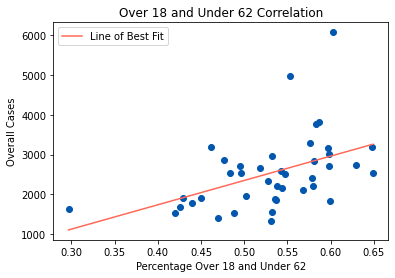

In [38]:
# Sorting by over_18_under_62, by ascending values.
df_middle_group = df_middle.sort_values("over_18_under_62", ascending = True)
middle = []
overall_cases = []
# Iterating over each row in dataframe.
for county in df_middle_group.index.values:
    # Getting the middle age value.
    middle.append(df_middle_group.loc[county, "over_18_under_62"])
    # Getting the overall cases.
    overall_cases.append(df_middle_group.loc[county].filter(regex = "cases").sum())

# Creating plot.
fig, axis = plt.subplots(1,1)
# Creating scatter plot of middle and overall_cases.
axis.scatter(middle, overall_cases, color = "#0157AE")
axis.title.set_text("Over 18 and Under 62 Correlation")
axis.set_ylabel("Overall Cases")
axis.set_xlabel("Percentage Over 18 and Under 62")
# Creating line of best fit.
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
m,b = np.polyfit(middle, overall_cases, 1)
# Plotting line of best fit.
t = axis.plot(middle, m * np.array(middle) + b, color = "#FF6958", label = "Line of Best Fit")
t = axis.legend(loc = "upper left")

#### We can see that as the over 18 and under 62 population percentage increases that the number of overall cases increases.

# Over 62 Percentage

In [39]:
# Getting the dataframe.
df_over_62 = df_merged_data
over_62_percentage = []
# Iterating over counties.
for county in df_over_62.index.values:
    # We take the over_or_62 values and divide it by the total population.
    # This will give us the percentage of over_or_62.
    over_62_percentage.append(df_middle.loc[county].over_or_62\
    / (df_over_62.loc[county].over_18\
    + df_over_62.loc[county].under_18))
# Populating dataframe with over_or_62 percentage.
df_over_62["over_62_percentage"] = over_62_percentage

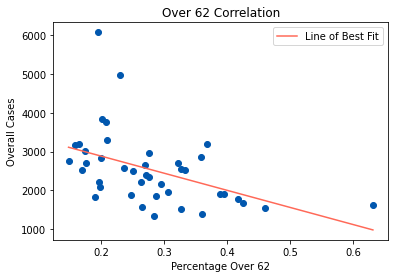

In [40]:
# Sorting by over_62_percentage, by ascending values.
df_older_group = df_over_62.sort_values("over_62_percentage", ascending = True)
older = []
overall_cases = []
# Iterating over each row in dataframe.
for county in df_older_group.index.values:
    # Getting the older age value.
    older.append(df_older_group.loc[county, "over_62_percentage"])
    # Getting the overall cases.
    overall_cases.append(df_older_group.loc[county].filter(regex = "cases").sum())

# Creating plot.
fig, axis = plt.subplots(1,1)
# Creating scatter plot of older and overall_cases.
axis.scatter(older, overall_cases, color = "#0157AE")
axis.title.set_text("Over 62 Correlation")
axis.set_ylabel("Overall Cases")
axis.set_xlabel("Percentage Over 62")
# Creating line of best fit.
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
m,b = np.polyfit(older, overall_cases, 1)
# Plotting line of best fit.
t = axis.plot(older, m * np.array(older) + b, color = "#FF6958", label = "Line of Best Fit")
t = axis.legend(loc = "upper right")

#### We can see that as the over 62 population percentage increases that the overall cases decreases.

# Housing Density

In [41]:
# Creating new dataframe.
df_housing_density = df_merged_data
housing_density = []
# Iterating over each row in dataframe.
for county in df_housing_density.index.values:
    # Calculating the housing density, population / total housing.
    housing_density.append((df_housing_density.loc[county].population_male\
    + df_housing_density.loc[county].population_female)\
    / df_housing_density.loc[county].total_housing)
# Creating column for housing density in dataframe.
df_housing_density["housing_density"] = housing_density


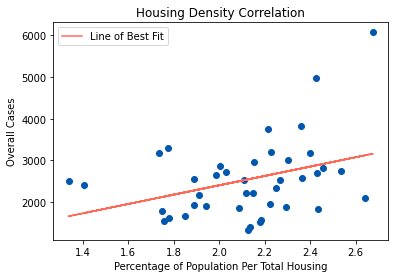

In [42]:
# Sorting dataframe by housing_density in ascending order.
df_house_density = df_housing_density.sort_values("housing_density", ascending = True)
housing_density = []
overall_cases = []
# Iterating over each county.
for county in df_median_age.index.values:
    # Getting the housing density.
    housing_density.append(df_house_density.loc[county, "housing_density"])
    # Getting the number of total cases.
    overall_cases.append(df_house_density.loc[county].filter(regex = "cases").sum())

# Creating figure.
fig, axis = plt.subplots(1,1)
# Creating scatter plot.
axis.scatter(housing_density, overall_cases, color = "#0157AE")
axis.title.set_text("Housing Density Correlation")
axis.set_ylabel("Overall Cases")
axis.set_xlabel("Percentage of Population Per Total Housing")
# Creating line of best fit.
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
m,b = np.polyfit(housing_density, overall_cases, 1)
# Plotting line of best fit.
axis.plot(housing_density, m * np.array(housing_density) + b, color = "#FF6958", label = "Line of Best Fit")
t = axis.legend(loc = "upper left")

#### We can see that as the percentage of population per total housing increases that the number of overall cases increases. In other words, as the housing density increases the number of cases increases.